In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import io
from google.colab import files
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
import holidays

# PARTE 1 - Segmentação de Clientes

In [4]:
df = pd.read_csv("/content/dados_limpos.csv")

In [6]:
df

,id_da_compra,id_do_cliente,data_da_compra,hora_da_compra,origem_ida,destino_ida,origem_retorno,destino_retorno,viacao_ida,viacao_retorno,valor_total,quantidade_passagens
0,localizador_1,passageiro_1,2018-12-26,15:33:35,lugar_1,lugar_2,sem retorno,sem retorno,viacao_1,Sem retorno,89.09,1
1,localizador_2,passageiro_2,2018-12-05,15:07:57,lugar_4,lugar_5,sem retorno,sem retorno,viacao_3,Sem retorno,155.97,1
2,localizador_3,passageiro_3,2018-12-21,18:41:54,lugar_6,lugar_7,sem retorno,sem retorno,viacao_4,Sem retorno,121.99,1
3,localizador_4,passageiro_4,2018-12-06,14:01:38,lugar_8,lugar_9,sem retorno,sem retorno,viacao_5,Sem retorno,55.22,1
4,localizador_5,passageiro_5,2021-02-23,20:08:25,lugar_6,lugar_10,sem retorno,sem retorno,viacao_6,Sem retorno,45.31,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1741339,localizador_1741340,passageiro_133024,2023-12-29,19:47:12,lugar_13,lugar_1,sem retorno,sem retorno,viacao_9,Sem retorno,156.00,1
1741340,localizador_1741341,passageiro_126144,2019-08-01,10:06:37,lugar_6,lugar_395,sem retorno,sem retorno,viacao_4,Sem retorno,106.93,2
1741341,localizador_1741342,passageiro_130048,2019-01-18,10:28:42,lugar_1,lugar_34,sem retorno,sem retorno,viacao_94,Sem retorno,92.77,1
1741342,localizador_1741343,passageiro_133024,2023-01-08,23:57:55,lugar_13,lugar_1,sem retorno,sem retorno,viacao_10,Sem retorno,294.99,1


In [7]:
# Converter data_da_compra para datetime
df['data_da_compra'] = pd.to_datetime(df['data_da_compra'])

In [8]:
# Criar coluna dia da semana (0=segunda, 6=domingo)
df['dia_semana'] = df['data_da_compra'].dt.dayofweek

In [9]:
# Importa a biblioteca holidays, que identifica feriados em diferentes países
br_feriados = holidays.Brazil(years=df['data_da_compra'].dt.year.unique())

In [10]:
# Coluna indicando se a viagem foi em feriado ou fim de semana
df['feriado_fds'] = ((df['dia_semana'] >= 5) | (df['data_da_compra'].isin(br_feriados))).astype(int)

/tmp/ipython-input-1500562027.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df['feriado_fds'] = ((df['dia_semana'] >= 5) | (df['data_da_compra'].isin(br_feriados))).astype(int)


In [11]:
# Agrupando por cliente
df_clientes = df.groupby("id_do_cliente").agg(
    ticket_medio=("valor_total", lambda x: np.mean(x / (df.loc[x.index, "quantidade_passagens"]))),
    qtd_destinos=("destino_ida", "nunique"),
    qtd_compras=("id_da_compra", "count"),
    qtd_passagens=("quantidade_passagens", "sum"),
    pct_feriados_fds=("feriado_fds", "mean")  # % de viagens em finais de semana/feriados
).reset_index()

df_clientes.head(10)

,id_do_cliente,ticket_medio,qtd_destinos,qtd_compras,qtd_passagens,pct_feriados_fds
0,passageiro_1,374.192000,4,5,6,0.400000
1,passageiro_10,74.768056,2,12,17,0.083333
2,passageiro_100,57.642128,4,47,47,0.446809
3,passageiro_1000,110.572143,2,7,14,0.142857
4,passageiro_10000,66.970000,1,1,1,0.000000
5,passageiro_100000,92.295000,2,2,2,0.000000
6,passageiro_100001,199.230000,1,1,1,1.000000
7,passageiro_100002,60.300000,1,1,1,0.000000
8,passageiro_100003,45.140000,1,1,1,1.000000
9,passageiro_100004,150.700000,1,2,2,0.000000


In [12]:
# Normalizando os dados (escalonamento)
# Importa o StandardScaler para normalizar os dados (ajusta média = 0 e desvio padrão = 1)
X = df_clientes[["ticket_medio", "qtd_destinos", "pct_feriados_fds"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# Importa o algoritmo KMeans, usado para segmentação de dados em grupos (clusters)
# Aplicando algoritmo de clusterização KMeans
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_pred = kmeans.fit_predict(X_scaled)

In [14]:
# adiciona os clusters no df
df_clientes["cluster"] = cluster_pred

In [15]:
# centróides na escala original
centros = scaler.inverse_transform(kmeans.cluster_centers_)

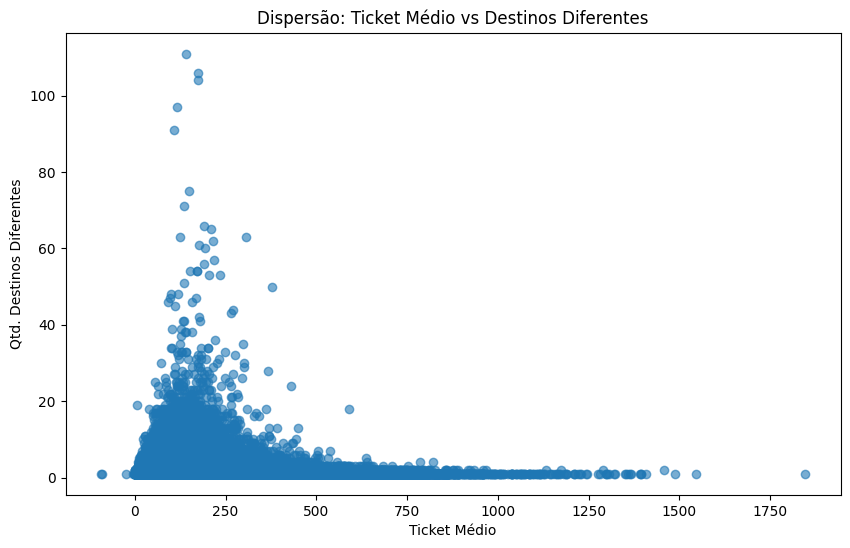

In [16]:
plt.figure(figsize=(10,6))
plt.scatter(df_clientes["ticket_medio"], df_clientes["qtd_destinos"], alpha=0.6)
plt.title("Dispersão: Ticket Médio vs Destinos Diferentes")
plt.xlabel("Ticket Médio")
plt.ylabel("Qtd. Destinos Diferentes")
plt.show()

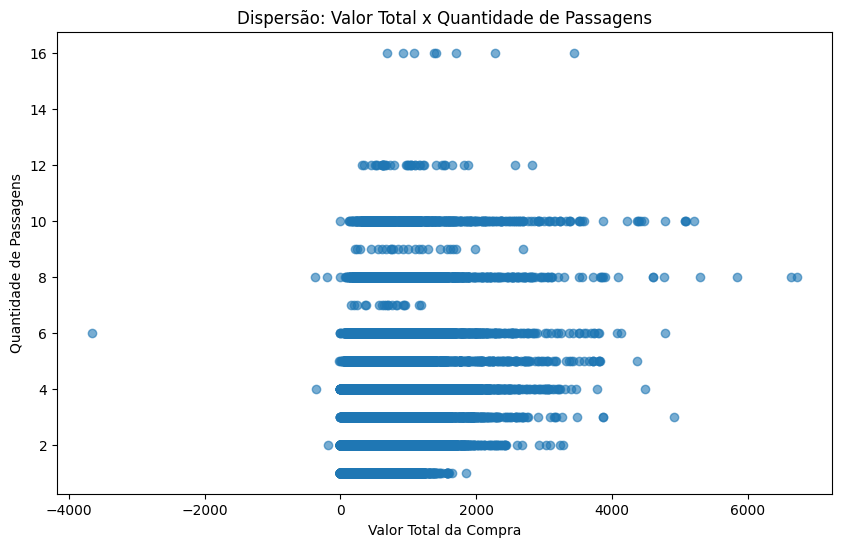

In [17]:
plt.figure(figsize=(10,6))
plt.scatter(df["valor_total"], df["quantidade_passagens"], alpha=0.6)
plt.title("Dispersão: Valor Total x Quantidade de Passagens")
plt.xlabel("Valor Total da Compra")
plt.ylabel("Quantidade de Passagens")
plt.show()

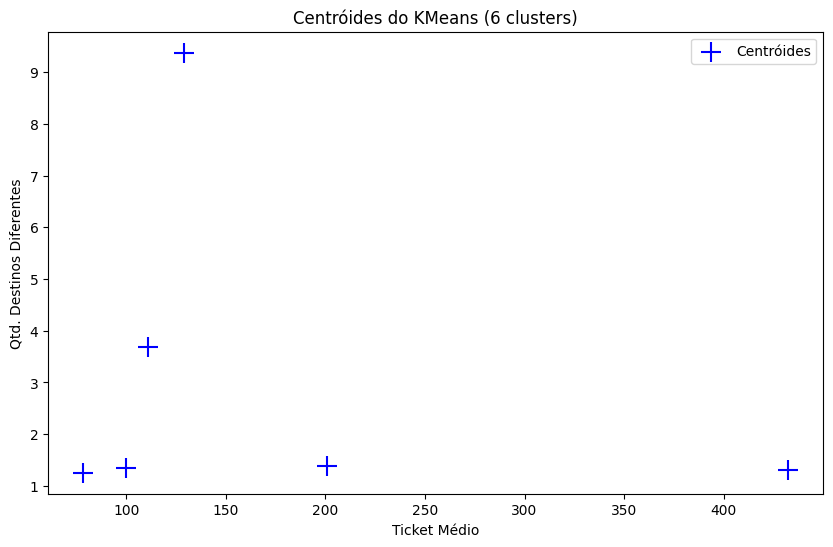

In [18]:
# Importa o algoritmo KMeans, usado para segmentação de dados em grupos (clusters)
# Aplicando algoritmo de clusterização KMeans
plt.figure(figsize=(10,6))
plt.scatter(centros[:,0], centros[:,1], s=200, c="blue", marker="+", label="Centróides")
plt.title("Centróides do KMeans (6 clusters)")
plt.xlabel("Ticket Médio")
plt.ylabel("Qtd. Destinos Diferentes")
plt.legend()
plt.show()

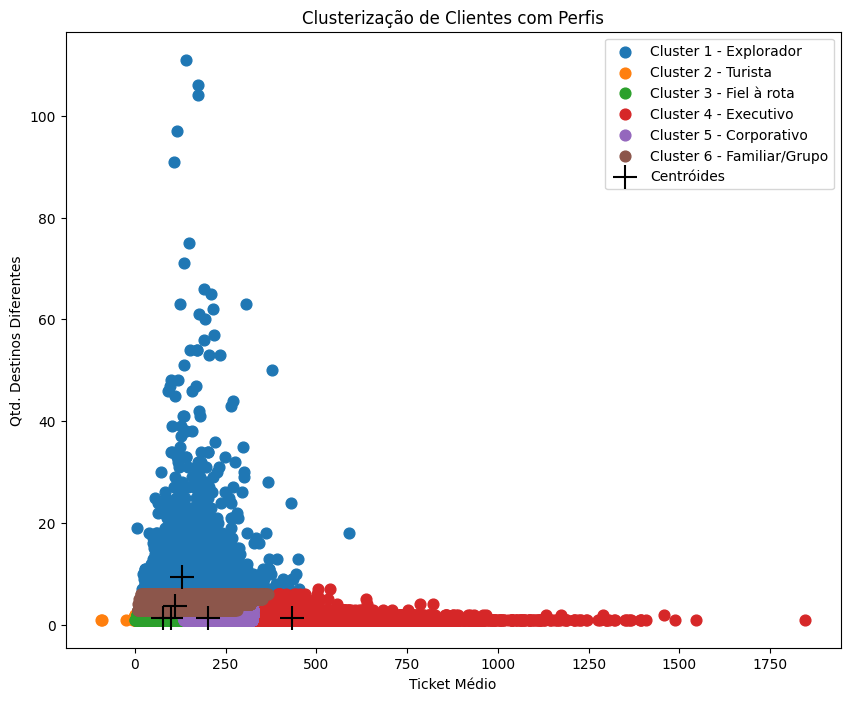

In [19]:
# Perfis
nomes_clusters = {
    0: "Explorador",
    1: "Turista",
    2: "Fiel à rota",
    3: "Executivo",
    4: "Corporativo",
    5: "Familiar/Grupo"
}

# Define tamanho da figura do gráfico
plt.figure(figsize=(10,8))

# Plota um scatter plot para cada cluster
for cluster_id in range(6):
    plt.scatter(
        df_clientes.loc[df_clientes["cluster"]==cluster_id, "ticket_medio"],
        df_clientes.loc[df_clientes["cluster"]==cluster_id, "qtd_destinos"],
        s=60,
        label=f'Cluster {cluster_id+1} - {nomes_clusters[cluster_id]}'
    )

# adiciona centróides
plt.scatter(centros[:,0], centros[:,1], marker="+", s=300, c="black", label="Centróides")

plt.title("Clusterização de Clientes com Perfis")
plt.xlabel("Ticket Médio")
plt.ylabel("Qtd. Destinos Diferentes")
plt.legend()
plt.show()


In [20]:
df_clientes["cluster"] = cluster_pred

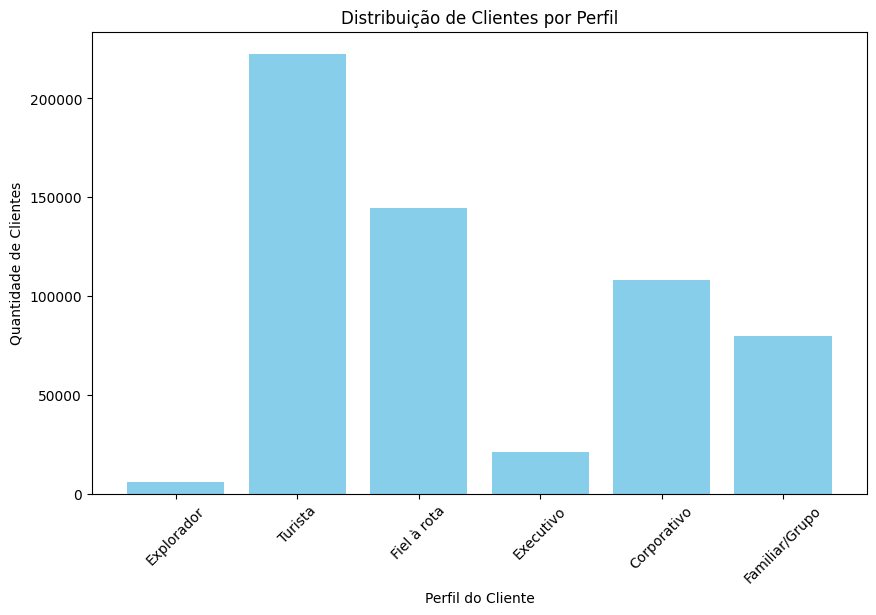

In [21]:
distribuicao = df_clientes['cluster'].value_counts().sort_index()
distribuicao.index = [nomes_clusters[i] for i in distribuicao.index]

plt.figure(figsize=(10,6))
plt.bar(distribuicao.index, distribuicao.values, color='skyblue')
plt.title("Distribuição de Clientes por Perfil")
plt.xlabel("Perfil do Cliente")
plt.ylabel("Quantidade de Clientes")
plt.xticks(rotation=45)
plt.show()

In [22]:
# Junta df com o cluster dos clientes pelo id, mantendo todos os registros de df
df = df.merge(df_clientes[['id_do_cliente', 'cluster']], on='id_do_cliente', how='left')

# Renomear
df = df.rename(columns={'cluster': 'cluster_num'})

In [23]:
# Cria a coluna com o nome do perfil usando o dicionário
df['cluster_nome'] = df['cluster_num'].map(nomes_clusters)

In [24]:
df

,id_da_compra,id_do_cliente,data_da_compra,hora_da_compra,origem_ida,destino_ida,origem_retorno,destino_retorno,viacao_ida,viacao_retorno,valor_total,quantidade_passagens,dia_semana,feriado_fds,cluster_num,cluster_nome
0,localizador_1,passageiro_1,2018-12-26,15:33:35,lugar_1,lugar_2,sem retorno,sem retorno,viacao_1,Sem retorno,89.09,1,2,0,3,Executivo
1,localizador_2,passageiro_2,2018-12-05,15:07:57,lugar_4,lugar_5,sem retorno,sem retorno,viacao_3,Sem retorno,155.97,1,2,0,4,Corporativo
2,localizador_3,passageiro_3,2018-12-21,18:41:54,lugar_6,lugar_7,sem retorno,sem retorno,viacao_4,Sem retorno,121.99,1,4,0,0,Explorador
3,localizador_4,passageiro_4,2018-12-06,14:01:38,lugar_8,lugar_9,sem retorno,sem retorno,viacao_5,Sem retorno,55.22,1,3,0,1,Turista
4,localizador_5,passageiro_5,2021-02-23,20:08:25,lugar_6,lugar_10,sem retorno,sem retorno,viacao_6,Sem retorno,45.31,1,1,0,2,Fiel à rota
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741339,localizador_1741340,passageiro_133024,2023-12-29,19:47:12,lugar_13,lugar_1,sem retorno,sem retorno,viacao_9,Sem retorno,156.00,1,4,0,5,Familiar/Grupo
1741340,localizador_1741341,passageiro_126144,2019-08-01,10:06:37,lugar_6,lugar_395,sem retorno,sem retorno,viacao_4,Sem retorno,106.93,2,3,0,5,Familiar/Grupo
1741341,localizador_1741342,passageiro_130048,2019-01-18,10:28:42,lugar_1,lugar_34,sem retorno,sem retorno,viacao_94,Sem retorno,92.77,1,4,0,5,Familiar/Grupo
1741342,localizador_1741343,passageiro_133024,2023-01-08,23:57:55,lugar_13,lugar_1,sem retorno,sem retorno,viacao_10,Sem retorno,294.99,1,6,1,5,Familiar/Grupo
